验证PyTorch安装：

In [ ]:
import torch
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用性: {torch.cuda.is_available()}")
print(f"CUDA版本: {torch.version.cuda}")

PyTorch版本: 2.6.0+cu124
CUDA可用性: True
CUDA版本: 12.4


安装detectron2

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vilqavqs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vilqavqs
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6434831 sha256=177313c14c0cf5ff2e3ed35afbc30a3e7c40098225ac3c4d410916d4dc1b5a6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mj4bqn3h/wheels/17/d9/40/60db98e485aa9455

验证detectron2

In [ ]:
from detectron2 import __version__
print(f"Detectron2版本: {__version__}")

Detectron2版本: 0.6


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Grayscale

In [ ]:
# =============================================================================
# Grayscale and overwrite the original file
# =============================================================================
import os
import cv2

root = "/content/drive/MyDrive/my_dataset"
species_dirs = [
    os.path.join(root, "Acer_tiles_downsampled_512"),
    os.path.join(root, "Betula_tiles_downsampled_512"),
    os.path.join(root, "Ulmaceae_tiles_downsampled_512"),
]

for species_dir in species_dirs:
    if not os.path.isdir(species_dir):
        print(f"Warning: Directory does not exist：{species_dir}")
        continue

    for fname in os.listdir(species_dir):
        if not fname.lower().endswith(".png"):
            continue
        fpath = os.path.join(species_dir, fname)
        img = cv2.imread(fpath)   # Color map
        if img is None:
            print(f"Warning: Unable to read {fpath}")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray3c = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)   # Three grayscale channels

        cv2.imwrite(fpath, gray3c)
    print(f"All PNG files in {species_dir} have been grayscaled.")

All PNG files in /content/drive/MyDrive/my_dataset/Acer_tiles_downsampled_512 have been grayscaled.
All PNG files in /content/drive/MyDrive/my_dataset/Betula_tiles_downsampled_512 have been grayscaled.
All PNG files in /content/drive/MyDrive/my_dataset/Ulmaceae_tiles_downsampled_512 have been grayscaled.


# Segmentatiaon model

合并train and val jason files

In [ ]:
# Convert the files
import json, os, cv2, itertools, datetime, re

entries = [
    # (VIA json, image folder, class name, split)
    ("/content/drive/MyDrive/my_dataset/Acer/train/Acer34_train.json",
     "/content/drive/MyDrive/my_dataset/Acer_tiles_downsampled_512", "Acer", "train"),
    ("/content/drive/MyDrive/my_dataset/Acer/val/Acer06_val.json",
     "/content/drive/MyDrive/my_dataset/Acer_tiles_downsampled_512", "Acer", "val"),
    ("/content/drive/MyDrive/my_dataset/Acer/test/Acer06_test.json",
     "/content/drive/MyDrive/my_dataset/Acer_tiles_downsampled_512", "Acer", "test"),

    ("/content/drive/MyDrive/my_dataset/Betula/train/Betula20_train.json",
     "/content/drive/MyDrive/my_dataset/Betula_tiles_downsampled_512", "Betula", "train"),
    ("/content/drive/MyDrive/my_dataset/Betula/val/Betula03_val.json",
     "/content/drive/MyDrive/my_dataset/Betula_tiles_downsampled_512", "Betula", "val"),
    ("/content/drive/MyDrive/my_dataset/Betula/test/Betula03_test.json",
     "/content/drive/MyDrive/my_dataset/Betula_tiles_downsampled_512", "Betula", "test"),

    ("/content/drive/MyDrive/my_dataset/Ulmaceae/train/Ulmaceae20_train.json",
     "/content/drive/MyDrive/my_dataset/Ulmaceae_tiles_downsampled_512", "Ulmaceae", "train"),
    ("/content/drive/MyDrive/my_dataset/Ulmaceae/val/Ulmaceae05_val.json",
     "/content/drive/MyDrive/my_dataset/Ulmaceae_tiles_downsampled_512", "Ulmaceae", "val"),
    ("/content/drive/MyDrive/my_dataset/Ulmaceae/test/Ulmaceae05_test.json",
     "/content/drive/MyDrive/my_dataset/Ulmaceae_tiles_downsampled_512", "Ulmaceae", "test"),
]

OUT_TRAIN = "/content/drive/MyDrive/my_dataset/Pollen/train/pollen_train_coco.json"
OUT_VAL   = "/content/drive/MyDrive/my_dataset/Pollen/val/pollen_val_coco.json"
OUT_TEST   = "/content/drive/MyDrive/my_dataset/Pollen/test/pollen_test_coco.json"
os.makedirs(os.path.dirname(OUT_TRAIN), exist_ok=True)
os.makedirs(os.path.dirname(OUT_VAL),   exist_ok=True)
os.makedirs(os.path.dirname(OUT_TEST),   exist_ok=True)

img_id, ann_id = 1, 1
name2cid = {}
coco_train = {"images": [], "annotations": []}
coco_val   = {"images": [], "annotations": []}
coco_test  = {"images": [], "annotations": []}

def safe_filename(entry, outer_key):
    if entry.get("filename"):
        return entry["filename"]
    m = re.match(r"(.+?)#\d+$", outer_key)
    if m:
        return os.path.basename(m.group(1))
    raise KeyError(f"cannot resolve filename for key {outer_key}")

def add_via(via_json, img_root, cls_name, target_dict):
    global img_id, ann_id, name2cid

    via = json.load(open(via_json))
    items = (via["_via_img_metadata"].items()
             if isinstance(via, dict) and "_via_img_metadata" in via
             else via.items()) if isinstance(via, dict) else enumerate(via)

    cid = name2cid.setdefault(cls_name, len(name2cid) + 1)

    for outer_key, ent in items:
        fname = safe_filename(ent, outer_key)
        fpath = os.path.join(img_root, fname)
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"{fpath} not found")

        h, w = cv2.imread(fpath).shape[:2]
        rel_path = os.path.relpath(fpath, "/content/drive/MyDrive/my_dataset")

        target_dict["images"].append({
            "id": img_id,
            "file_name": rel_path,
            "height": h,
            "width":  w
        })

        for reg in ent["regions"]:
            xs, ys = reg["shape_attributes"]["all_points_x"], reg["shape_attributes"]["all_points_y"]
            x0, y0 = min(xs), min(ys)
            bw, bh = max(xs) - x0, max(ys) - y0
            poly   = list(itertools.chain.from_iterable(zip(xs, ys)))
            target_dict["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cid,
                "bbox": [x0, y0, bw, bh],
                "area": bw * bh,
                "segmentation": [poly],
                "iscrowd": 0
            })
            ann_id += 1
        img_id += 1

for via_json, img_dir, cls, split in entries:
    target = {"train": coco_train, "val": coco_val, "test": coco_test}[split]
    add_via(via_json, img_dir, cls, target)

def finalize(coco_obj):
    coco_obj["info"] = {"description": "Merged pollen dataset",
                        "year": datetime.datetime.now().year}
    coco_obj["licenses"] = []
    coco_obj["categories"] = [{"id": cid, "name": name, "supercategory": "pollen"}
                              for name, cid in name2cid.items()]

for c in (coco_train, coco_val, coco_test): finalize(c)

finalize(coco_train)
finalize(coco_val)

json.dump(coco_train, open(OUT_TRAIN, "w"))
json.dump(coco_val,   open(OUT_VAL,   "w"))
json.dump(coco_test,  open(OUT_TEST,  "w"))
print(f"train : {len(coco_train['images'])} images | {len(coco_train['annotations'])} anns")
print(f"val   : {len(coco_val['images'])} images | {len(coco_val['annotations'])} anns")
print(f"test  : {len(coco_test['images'])} images | {len(coco_test['annotations'])} anns")

# Register the merged COCO to detectron2
from detectron2.data.datasets import register_coco_instances

root = "/content/drive/MyDrive/my_dataset"
register_coco_instances("pollen_train", {}, OUT_TRAIN, root)
register_coco_instances("pollen_val",   {}, OUT_VAL,   root)
register_coco_instances("pollen_test",  {}, OUT_TEST,  root)


train : 74 images | 2489 anns
val   : 14 images | 493 anns
test  : 14 images | 480 anns


To verify the dataset is in correct format.

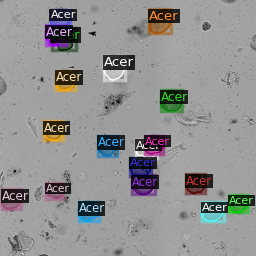

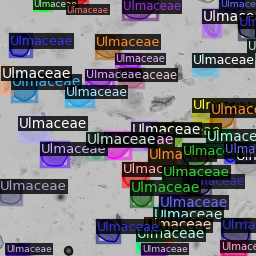

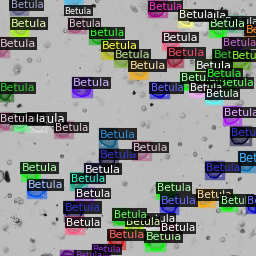

In [ ]:
import random, os, cv2, sys
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

# dataset name registered earlier
ds_name   = "pollen_train"
image_root = "/content/drive/MyDrive/my_dataset"   # same root used in register_coco_instances

dataset_dicts = DatasetCatalog.get(ds_name)
meta          = MetadataCatalog.get(ds_name)

for d in random.sample(dataset_dicts, 3):
    # build absolute path if file_name is relative
    img_path = d["file_name"]
    if not os.path.isabs(img_path):
        img_path = os.path.join(image_root, img_path)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] cannot read {img_path}", file=sys.stderr)
        continue

    vis = Visualizer(img[:, :, ::-1], metadata=meta, scale=0.5)
    vis_img = vis.draw_dataset_dict(d).get_image()
    cv2_imshow(vis_img[:, :, ::-1])


Train Mask R-CNN on the merged pollen dataset (3 classes) 2025.6.10

In [ ]:
import os
import torch
from detectron2.engine import DefaultTrainer, hooks
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader, DatasetMapper
from detectron2.data import DatasetMapper, get_detection_dataset_dicts, MapDataset
from detectron2.data.samplers import InferenceSampler
from torch.utils.data import DataLoader


# Custom validation loss hook
class LossEvalHook(hooks.HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._period = eval_period
        self._model = model
        self._data_loader = data_loader

    def after_step(self):
        if self.trainer.iter % self._period == 0:
            print(f"[hook] Running validation loss at iteration {self.trainer.iter}")
            self._model.train()
            with torch.no_grad():
              losses = []
              for batch in self._data_loader:
                  print(f"[hook] got batch of size: {len(batch)}")
                  batch = [x for x in batch if "instances" in x and len(x["instances"]) > 0]
                  if not batch:
                      print("[hook] skipped empty batch (no instances)")
                      continue
                  try:
                      loss_dict = self._model(batch)
                      total_loss = sum(loss_dict.values()).item()
                      print(f"[hook] total_loss = {total_loss:.4f}")
                      losses.append(total_loss)
                  except Exception as e:
                      print(f"[hook] Skipped batch due to error: {e}")

              if losses:
                  avg_loss = sum(losses) / len(losses)
                  print(f"[hook] avg validation loss = {avg_loss:.4f}")
                  self.trainer.storage.put_scalar("validation_total_loss", avg_loss)
              else:
                  print("[hook] No valid losses to average.")
            self._model.train()

def trivial_batch_collator(batch):
    return batch

def build_val_loader(cfg, batch_size=4):
    dataset_dicts = get_detection_dataset_dicts([cfg.DATASETS.TEST[0]])
    mapper = DatasetMapper(cfg, is_train=True)
    dataset = MapDataset(dataset_dicts, mapper)
    sampler = InferenceSampler(len(dataset))
    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        collate_fn=trivial_batch_collator
    )

# Customize Trainer and add hook
class MyTrainer(DefaultTrainer):
    def build_hooks(self):
        hooks_list = super().build_hooks()

        # Set loader with batch_size=4
        val_loader = build_val_loader(self.cfg, batch_size=4)

        hooks_list.insert(-1, LossEvalHook(self.cfg.TEST.EVAL_PERIOD, self.model, val_loader))
        return hooks_list

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Basic configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("pollen_train",)
cfg.DATASETS.TEST  = ("pollen_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)

# solver (learning-rate & schedule)
cfg.SOLVER.IMS_PER_BATCH = 4   # batch-size = 4 images / iteration
cfg.SOLVER.BASE_LR = 2.5e-4   # smaller LR for small dataset
cfg.SOLVER.MAX_ITER = 3000   # raise if you need better accuracy
cfg.SOLVER.STEPS = []   # no LR decay

cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.TEST.EVAL_PERIOD = 200

# model head
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Acer, Betula, Ulmaceae

# output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/my_dataset/pollen_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# start training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[07/05 15:25:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 126MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/05 15:25:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[hook] Running validation loss at iteration 0
[hook] got batch of size: 4
[hook] total_loss = 3.3082
[hook] got batch of size: 4
[hook] total_loss = 4.3058
[hook] got batch of size: 4
[hook] total_loss = 3.7513
[hook] got batch of size: 2
[hook] total_loss = 3.4861
[hook] avg validation loss = 3.7128
[07/05 15:25:57 d2.utils.events]:  eta: 0:35:07  iter: 19  total_loss: 3.755  loss_cls: 1.327  loss_box_reg: 0.723  loss_mask: 0.6923  loss_rpn_cls: 0.8882  loss_rpn_loc: 0.07915  validation_total_loss: 3.713    time: 0.6911  last_time: 0.7136  data_time: 0.0328  last_data_time: 0.0141   lr: 4.9953e-06  max_mem: 3096M
[07/05 15:26:18 d2.utils.events]:  eta: 0:34:59  iter: 39  total_loss: 2.93  loss_cls: 1.219  loss_box_reg: 0.7466  loss_mask: 0.6852  loss_rpn_cls: 0.196  loss_rpn_loc: 0.07621  validation_total_loss: 3.713    time: 0.6940  last_time: 0.7371  data_time: 0.0204  last_data_time: 0.0137   lr: 9.9902e-06  max_mem: 3096M
[07/05 15:26:32 d2.utils.events]:  eta: 0:34:45  iter: 59  

Visualizing train and val total loss

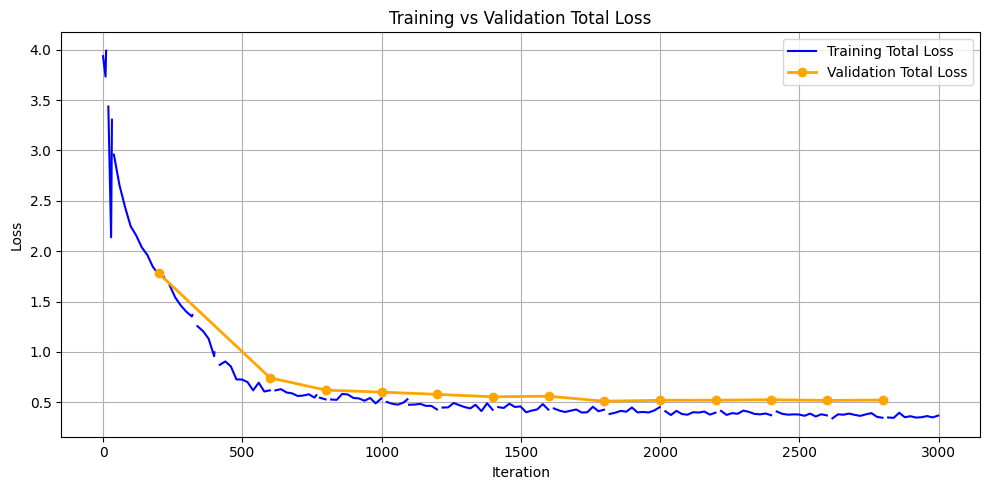

In [ ]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

# 读取日志
log_file = pathlib.Path("/content/drive/MyDrive/my_dataset/pollen_output/metrics.json")
records = [json.loads(line) for line in log_file.open()]
df = pd.DataFrame(records)
df = df.drop_duplicates(subset="iteration").sort_values("iteration")

# 绘图
plt.figure(figsize=(10, 5))

# 训练 loss
if "total_loss" in df.columns:
    plt.plot(df["iteration"], df["total_loss"], label="Training Total Loss", color='blue')

# 验证 loss（稀疏点 + marker）
if "validation_total_loss" in df.columns:
    val_df = df[["iteration", "validation_total_loss"]].dropna()
    plt.plot(val_df["iteration"], val_df["validation_total_loss"], label="Validation Total Loss", color='orange', marker='o', linewidth=2)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training vs Validation Total Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Inference using the trained segmentation model

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import os, json

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("pollen_train",)
cfg.DATASETS.TEST = ("pollen_test",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = "/content/drive/MyDrive/my_dataset/pollen_output"

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # Confidence threshold
cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)

# Evaluating COCO metrics
evaluator = COCOEvaluator("pollen_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
test_loader = build_detection_test_loader(cfg, "pollen_test")
metrics = inference_on_dataset(predictor.model, test_loader, evaluator)
print("Test metrics:", json.dumps(metrics, indent=2))


[07/05 16:14:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/my_dataset/pollen_output/model_final.pth ...
WARNING [07/05 16:14:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/05 16:14:15 d2.data.datasets.coco]: Loaded 14 images in COCO format from /content/drive/MyDrive/my_dataset/Pollen/test/pollen_test_coco.json
[07/05 16:14:15 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    Acer    | 107          |   Betula   | 98           |  Ulmaceae  | 275          |
|            |              |            |              |            |              |
|   total    | 480          |            |              |            |              |
[07/05 16:14:15

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/05 16:14:16 d2.evaluation.evaluator]: Inference done 11/14. Dataloading: 0.0009 s/iter. Inference: 0.0837 s/iter. Eval: 0.0209 s/iter. Total: 0.1055 s/iter. ETA=0:00:00
[07/05 16:14:17 d2.evaluation.evaluator]: Total inference time: 0:00:01.108880 (0.123209 s / iter per device, on 1 devices)
[07/05 16:14:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.085198 s / iter per device, on 1 devices)
[07/05 16:14:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/05 16:14:18 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/my_dataset/pollen_output/coco_instances_results.json
[07/05 16:14:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[07/05 16:14:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/05 16:14:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 

Use segmentation model to crop and save pollen instances

In [ ]:
import os, cv2, torch
from glob import glob
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import re

# Set input directories for training and validation images
train_dir = "/content/drive/MyDrive/my_dataset/Pollen/train"
val_dir = "/content/drive/MyDrive/my_dataset/Pollen/val"
all_images = glob(f"{train_dir}/*.png") + glob(f"{val_dir}/*.png")

# Set output directory for cropped pollen images
save_root = "/content/drive/MyDrive/my_dataset/Classification"
os.makedirs(save_root, exist_ok=True)

# List of pollen species
species_list = ["Acer", "Betula", "Ulmaceae"]
for sp in species_list:
    os.makedirs(os.path.join(save_root, sp), exist_ok=True)

# Start batch processing
print(f"Found {len(all_images)} images. Starting inference and crop saving...")

for img_path in tqdm(all_images):
    # Determine species from filename prefix
    filename = os.path.basename(img_path)
    matched = [sp for sp in species_list if filename.startswith(sp)]
    if not matched:
        print(f"Skipping unknown species: {filename}")
        continue
    species = matched[0]

    # Inference using trained Detectron2 segmentation model
    image = cv2.imread(img_path)
    outputs = predictor(image)
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

    # Crop and save each detected instance
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        crop = image[y1:y2, x1:x2]

        # Convert to grayscale
        gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

        # Extract 4-digit tile ID from filename
        basename = os.path.splitext(filename)[0]
        match = re.search(r"tile_(\d{4})", basename)
        img_id = match.group(1) if match else "0000"

        # Construct simplified filename, e.g., Acer_0051_crop0.jpg
        new_name = f"{species}_{img_id}_crop{i}.jpg"
        out_path = os.path.join(save_root, species, new_name)

        # Save the cropped grayscale image
        cv2.imwrite(out_path, gray_crop)

print("All crops have been saved successfully.")


Found 102 images. Starting inference and crop saving...


100%|██████████| 102/102 [19:02<00:00, 11.20s/it]

✅ All crops have been saved successfully.


Visualize the image

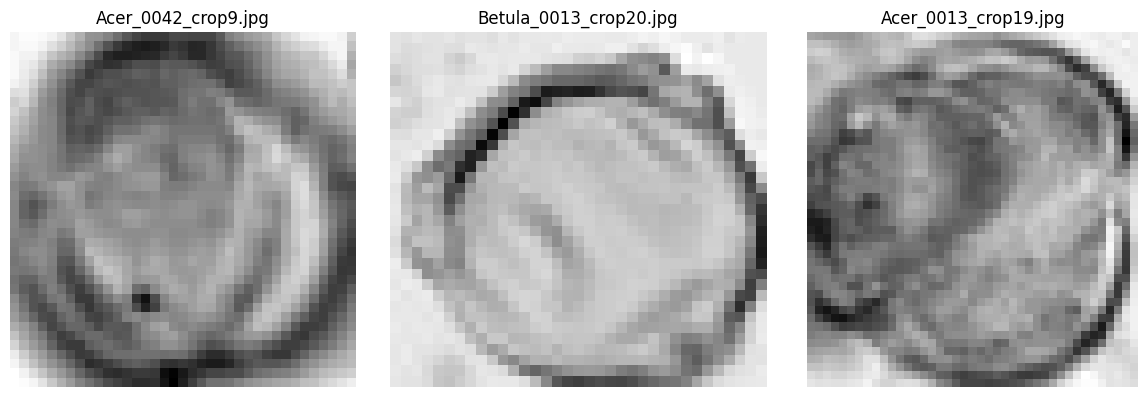

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 设置保存图像的根目录（与你上面代码中的 save_root 相同）
save_root = "/content/drive/MyDrive/my_dataset/Classification"

# 遍历所有子类文件夹，收集所有图像路径
all_saved_images = []
for sp in os.listdir(save_root):
    sp_dir = os.path.join(save_root, sp)
    if os.path.isdir(sp_dir):
        image_files = [os.path.join(sp_dir, f) for f in os.listdir(sp_dir) if f.endswith(".jpg")]
        all_saved_images.extend(image_files)

# 随机选取 3 张图像
sample_images = random.sample(all_saved_images, 3)

# 显示图像
plt.figure(figsize=(12, 4))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


Extracting basic information from pollen images

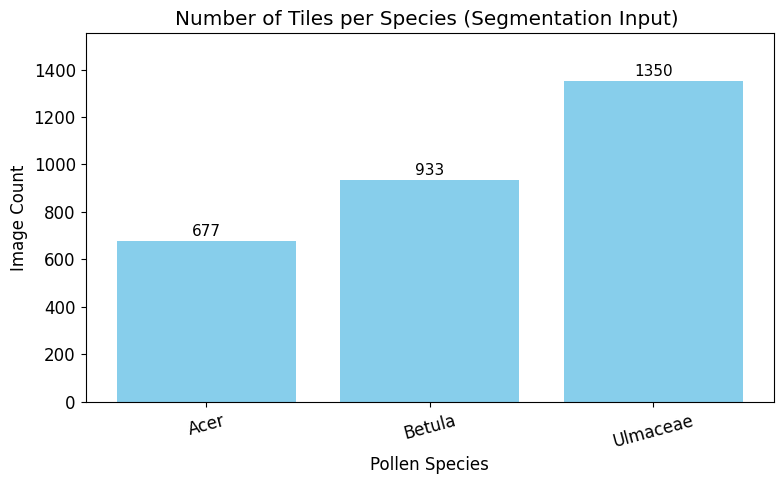

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Font settings
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Path to dataset
data_dir = "/content/drive/MyDrive/my_dataset/Classification_uniform"

# Count images per species
species_counts = defaultdict(int)
for species in os.listdir(data_dir):
    sp_dir = os.path.join(data_dir, species)
    if os.path.isdir(sp_dir):
        images = [f for f in os.listdir(sp_dir) if f.endswith(".jpg")]
        species_counts[species] = len(images)

# Order: Acer → Betula → Ulmaceae
desired_order = ["Acer", "Betula", "Ulmaceae"]
ordered_counts = {sp: species_counts[sp] for sp in desired_order}

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(ordered_counts.keys(), ordered_counts.values(), color='skyblue')
plt.ylim(0, max(ordered_counts.values()) * 1.15)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height:.0f}',
             ha='center', va='bottom', fontsize=11)

plt.title("Number of Tiles per Species (Segmentation Input) ")
plt.xlabel("Pollen Species")
plt.ylabel("Image Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Crop pollen instances using segmentation masks and save with transparent background 花粉边框

In [ ]:
import os
import cv2
import numpy as np
import re
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# 设置分割模型配置
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/my_dataset/pollen_output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)

# 物种及其原始图像目录
species_list = ["Acer", "Betula", "Ulmaceae"]
base_dir = "/content/drive/MyDrive/my_dataset"
image_dirs = [os.path.join(base_dir, f"{sp}_tiles_downsampled_512") for sp in species_list]

# 输出目录
save_root = os.path.join(base_dir, "MaskedTransparent")
os.makedirs(save_root, exist_ok=True)
for sp in species_list:
    os.makedirs(os.path.join(save_root, sp), exist_ok=True)

# 批量处理所有图像
for sp, sp_dir in zip(species_list, image_dirs):
    image_files = [f for f in os.listdir(sp_dir) if f.lower().endswith(".png")]

    for fname in tqdm(image_files, desc=f"Processing {sp}"):
        img_path = os.path.join(sp_dir, fname)
        image = cv2.imread(img_path)
        if image is None:
            continue

        outputs = predictor(image)
        masks = outputs["instances"].pred_masks.cpu().numpy()

        for i, mask in enumerate(masks):
            mask = mask.astype(np.uint8) * 255
            ys, xs = np.where(mask > 0)
            if len(xs) == 0 or len(ys) == 0:
                continue
            x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
            crop_img = image[y1:y2+1, x1:x2+1]
            crop_mask = mask[y1:y2+1, x1:x2+1]

            # 创建透明图像（BGRA）
            crop_bgra = cv2.cvtColor(crop_img, cv2.COLOR_BGR2BGRA)
            crop_bgra[:, :, 3] = crop_mask  # 设置 alpha 通道

            # 命名方式：包含 slide ID 和 tile 编号
            match_tile = re.search(r"tile_(\d{4})", fname)
            tile_id = match_tile.group(1) if match_tile else "xxxx"

            match_slide = re.search(r"(BM_\d+)", fname)
            slide_id = match_slide.group(1) if match_slide else "BM_xxxx"

            out_name = f"{sp}_{slide_id}_{tile_id}_mask{i}.png"
            out_path = os.path.join(save_root, sp, out_name)
            cv2.imwrite(out_path, crop_bgra)

print("All pollen images have been saved as transparent images")


Processing Ulmaceae: 100%|██████████| 768/768 [06:33<00:00,  1.95it/s]

All pollen images have been saved as transparent images


Visualization

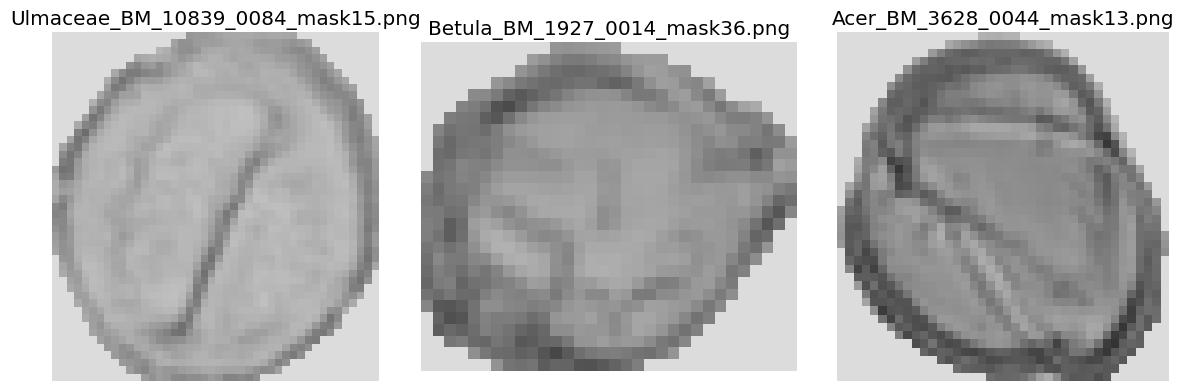

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 图像目录
base_dir = "/content/drive/MyDrive/my_dataset/MaskedTransparent"
species_list = ["Acer", "Betula", "Ulmaceae"]

# 收集所有图像路径
all_images = []
for sp in species_list:
    sp_dir = os.path.join(base_dir, sp)
    files = [os.path.join(sp_dir, f) for f in os.listdir(sp_dir) if f.endswith(".png")]
    all_images.extend(files)

# 随机选取 3 张图像
sample_paths = random.sample(all_images, 3)

# 可视化
plt.figure(figsize=(12, 4))
for i, path in enumerate(sample_paths):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # 保留 alpha 通道
    img_rgb = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2RGB)
    alpha = img[:, :, 3]

    # 将透明区域变为灰色背景（可选）
    img_rgb[alpha == 0] = [220, 220, 220]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(os.path.basename(path))
    plt.axis("off")

plt.tight_layout()
plt.show()

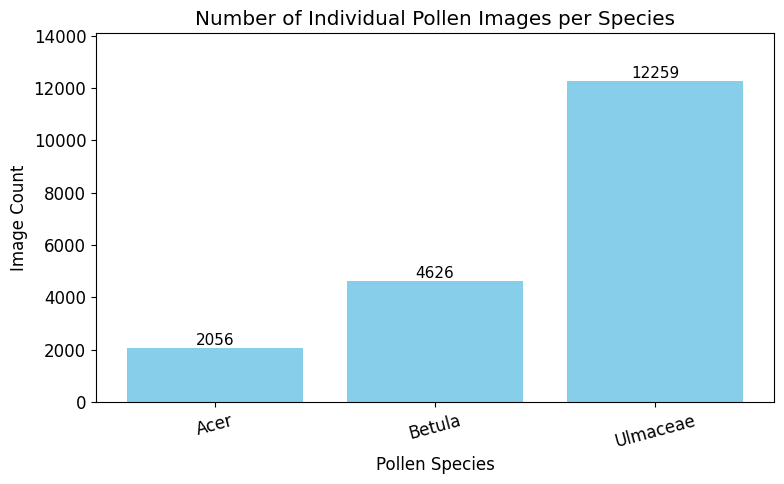

In [ ]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# 设置字体和样式（与 Classification_uniform 代码一致）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 数据集路径：MaskedTransparent 文件夹
data_dir = "/content/drive/MyDrive/my_dataset/MaskedTransparent"

# 统计每个物种的图像数量
species_counts = defaultdict(int)
for species in os.listdir(data_dir):
    sp_dir = os.path.join(data_dir, species)
    if os.path.isdir(sp_dir):
        images = [f for f in os.listdir(sp_dir) if f.lower().endswith(".png")]
        species_counts[species] = len(images)

# 绘图
plt.figure(figsize=(8, 5))
bars = plt.bar(species_counts.keys(), species_counts.values(), color='skyblue')

# 设置 y 轴最大值，防止文字被截断
plt.ylim(0, max(species_counts.values()) * 1.15)

# 添加数值标签在每根柱子上
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{height:.0f}',
             ha='center', va='bottom', fontsize=11)

# 图表标题和轴标签
plt.title("Number of Individual Pollen Images per Species")
plt.xlabel("Pollen Species")
plt.ylabel("Image Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# Classification model ResNet50

Count the maximum size of crops

In [ ]:
import os
import cv2

base_dir = "/content/drive/MyDrive/my_dataset/Classification"
species_list = ["Acer", "Betula", "Ulmaceae"]

max_h, max_w = 0, 0

for sp in species_list:
    folder = os.path.join(base_dir, sp)
    for f in os.listdir(folder):
        if f.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                h, w = img.shape
                max_h = max(max_h, h)
                max_w = max(max_w, w)

print(f"Maximum pollen size：height = {max_h}, width = {max_w}")


Maximum pollen size：height = 84, width = 66


Center alignment + black border padding

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# 固定目标尺寸
TARGET_H, TARGET_W = 84, 84
PAD_COLOR = 0  # 黑色背景

# 输入输出路径
src_root = "/content/drive/MyDrive/my_dataset/Classification"
dst_root = "/content/drive/MyDrive/my_dataset/Classification_uniform"
species_list = ["Acer", "Betula", "Ulmaceae"]

# 中心填充函数（不缩放）
def pad_to_target_size(img, target_h, target_w, pad_value=0):
    h, w = img.shape
    assert h <= target_h and w <= target_w, f"Image larger than target: {h}x{w}"

    pad_top = (target_h - h) // 2
    pad_bottom = target_h - h - pad_top
    pad_left = (target_w - w) // 2
    pad_right = target_w - w - pad_left

    padded = cv2.copyMakeBorder(
        img, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=pad_value
    )
    return padded

# 批处理每类图像
for sp in species_list:
    src_dir = os.path.join(src_root, sp)
    dst_dir = os.path.join(dst_root, sp)
    os.makedirs(dst_dir, exist_ok=True)

    for fname in tqdm(os.listdir(src_dir), desc=f"Processing {sp}"):
        if not fname.endswith(".jpg"):
            continue
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)

        img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Read failed: {fname}")
            continue

        h, w = img.shape
        if h > TARGET_H or w > TARGET_W:
            print(f"Image too large, skipping: {fname} ({h}x{w})")
            continue

        padded = pad_to_target_size(img, TARGET_H, TARGET_W, pad_value=PAD_COLOR)
        cv2.imwrite(dst_path, padded)

print("All crops have saved.")


Processing Ulmaceae: 100%|██████████| 1350/1350 [12:12<00:00,  1.84it/s]

All crops have saved.


resize成224像素 transforms.Resize

In [4]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode

train_tf = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])


Visual inspection

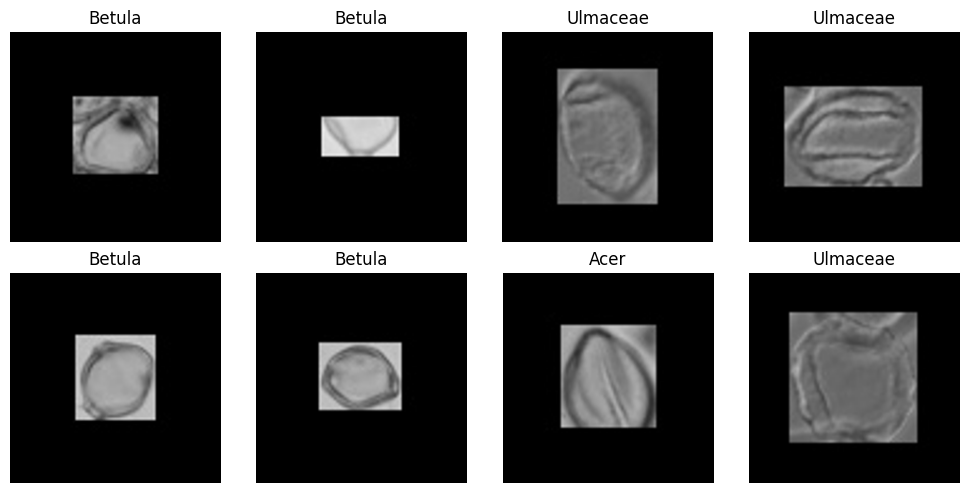

In [7]:
# ==== 可视化 224×224 的图片 ====
import os, random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode

# 路径：指向你 84×84 的数据（transform 会自动放大到 224）
data_dir = "/content/drive/MyDrive/my_dataset/Classification_uniform"

# 定义 transform（含 Resize 到 224）
tf = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# 构建数据集（不需要 DataLoader，只是想看图片）
ds = datasets.ImageFolder(data_dir, transform=tf)

# 随机显示几张
fig, axes = plt.subplots(2, 4, figsize=(10,5))
for ax in axes.flatten():
    idx = random.randint(0, len(ds)-1)
    img, label = ds[idx]  # (C,H,W), label index
    ax.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
    ax.set_title(ds.classes[label])
    ax.axis("off")
plt.tight_layout()
plt.show()


Define dataset and transformations 70 15 15

Epoch 1/10  |  Val Acc: 88.64%
Epoch 2/10  |  Val Acc: 92.95%
Epoch 3/10  |  Val Acc: 76.36%
Epoch 4/10  |  Val Acc: 91.82%
Epoch 5/10  |  Val Acc: 92.95%
Epoch 6/10  |  Val Acc: 95.00%
Epoch 7/10  |  Val Acc: 95.68%
Epoch 8/10  |  Val Acc: 87.27%
Epoch 9/10  |  Val Acc: 94.55%
Epoch 10/10  |  Val Acc: 94.32%

TEST Acc: 96.14%
              precision    recall  f1-score   support

        Acer       0.90      0.94      0.92       102
      Betula       0.99      0.98      0.99       141
    Ulmaceae       0.97      0.96      0.97       197

    accuracy                           0.96       440
   macro avg       0.95      0.96      0.96       440
weighted avg       0.96      0.96      0.96       440



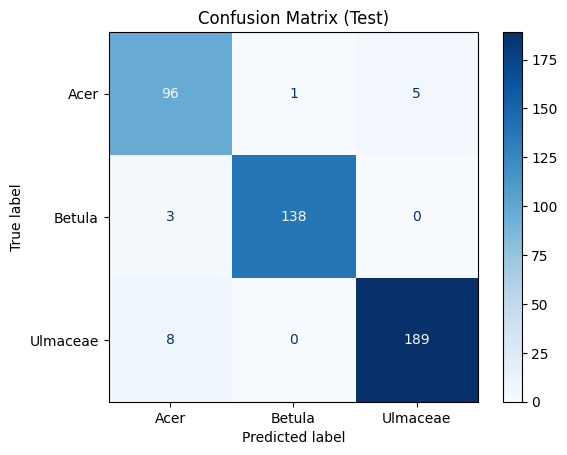

In [12]:
# ==== Define dataset and transformations (fixed 70:15:15, 224px, class weights) ====
import os, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ==== 可改参数 ====
data_dir   = "/content/drive/MyDrive/my_dataset/Classification_uniform"
batch_size = 4
epochs     = 10
lr         = 1e-3
val_ratio  = 0.15
test_ratio = 0.15
# ==================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- 224×224：灰度→3通道 + ImageNet 归一化（适配预训练ResNet）----
train_tf = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

# ---- 数据集 ----
full_ds       = datasets.ImageFolder(data_dir, transform=eval_tf)
train_ds_full = datasets.ImageFolder(data_dir, transform=train_tf)

# 读取固定划分索引（已在上一单元格生成）
split_cache = os.path.join(data_dir, f"split_v{int(val_ratio*100)}_{int(test_ratio*100)}.npz")
npz = np.load(split_cache)
train_idx, val_idx, test_idx = npz["train"], npz["val"], npz["test"]

train_ds = Subset(train_ds_full, train_idx)
val_ds   = Subset(full_ds,       val_idx)
test_ds  = Subset(full_ds,       test_idx)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ---- 模型 ----
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(full_ds.classes))
model = model.to(device)

# ---- 损失（类权重） & 优化器 ----
class_weights = torch.tensor([1.46, 1.06, 0.73], dtype=torch.float32, device=device)  # [Acer, Betula, Ulmaceae]
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# ---- 训练与验证 ----
for epoch in range(1, epochs + 1):
    # 训练
    model.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # 验证
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
    acc = 100.0 * correct / max(total, 1)
    print(f'Epoch {epoch}/{epochs}  |  Val Acc: {acc:.2f}%')

# ---- 最终测试评估（一次）----
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        out = model(x).argmax(1).cpu()
        all_preds.append(out)
        all_labels.append(y)
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = (all_preds == all_labels).mean() * 100.0
print(f"\nTEST Acc: {test_acc:.2f}%")
print(classification_report(all_labels, all_preds, target_names=full_ds.classes))

# 混淆矩阵可视化（论文更直观）
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_ds.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test)")
plt.show()


In [ ]:
print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_idx)}")
print(f"Val:   {len(val_idx)}")
print(f"Test:  {len(test_idx)}")

Total images: 2960
Train: 2049
Val:   440
Test:  440


test 使用折线图（line plot）而非表格来展示 epoch-level accuracy

Epoch 01/10 | Train Acc 94.83% | Val Acc 92.50% | Train Loss 0.1455 | Val Loss 0.1779
Epoch 02/10 | Train Acc 94.34% | Val Acc 97.27% | Train Loss 0.1696 | Val Loss 0.0682
Epoch 03/10 | Train Acc 95.36% | Val Acc 96.82% | Train Loss 0.1217 | Val Loss 0.0721
Epoch 04/10 | Train Acc 94.83% | Val Acc 95.45% | Train Loss 0.1364 | Val Loss 0.1099
Epoch 05/10 | Train Acc 95.41% | Val Acc 97.05% | Train Loss 0.1200 | Val Loss 0.0738
Epoch 06/10 | Train Acc 95.56% | Val Acc 98.18% | Train Loss 0.1322 | Val Loss 0.0551
Epoch 07/10 | Train Acc 96.00% | Val Acc 97.05% | Train Loss 0.1080 | Val Loss 0.0684
Epoch 08/10 | Train Acc 95.66% | Val Acc 96.82% | Train Loss 0.1165 | Val Loss 0.0807
Epoch 09/10 | Train Acc 96.24% | Val Acc 97.50% | Train Loss 0.0916 | Val Loss 0.0541
Epoch 10/10 | Train Acc 96.00% | Val Acc 97.95% | Train Loss 0.1024 | Val Loss 0.0639


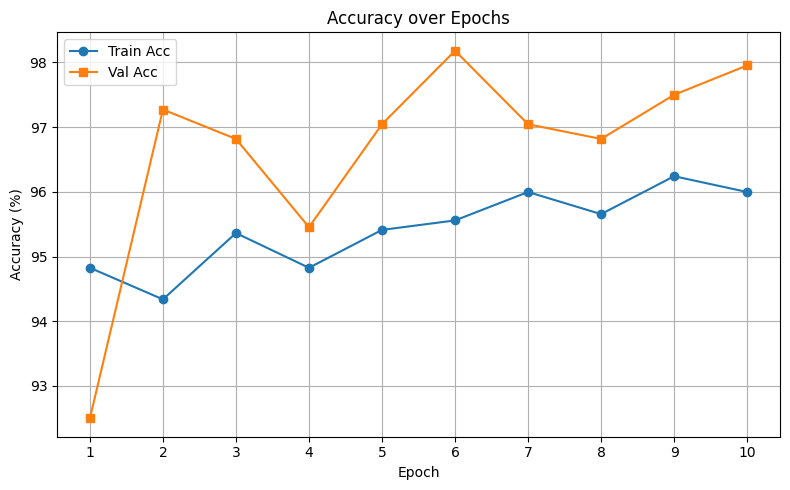

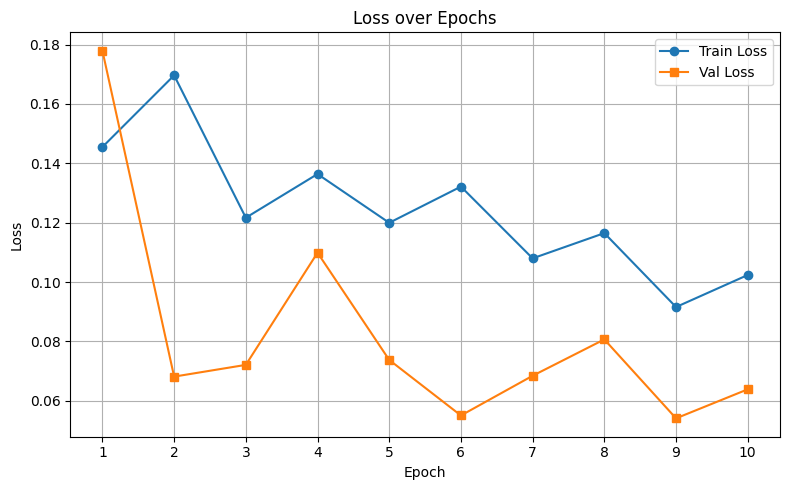

In [ ]:
# ===== 训练 + 验证（记录每个 epoch 的指标，用折线图展示）=====
import matplotlib.pyplot as plt

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(1, epochs + 1):
    # ---- 训练 ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total   += y.size(0)
    train_loss = running_loss / max(total, 1)
    train_acc  = 100.0 * correct / max(total, 1)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ---- 验证 ----
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item() * x.size(0)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
    val_loss = running_loss / max(total, 1)
    val_acc  = 100.0 * correct / max(total, 1)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}% | "
          f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

# ===== 折线图：Accuracy over Epochs =====
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_acc_list, marker='o', label='Train Acc')
plt.plot(range(1, epochs+1), val_acc_list,   marker='s', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.xticks(range(1, epochs+1))
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

# （可选）折线图：Loss over Epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_loss_list, marker='o', label='Train Loss')
plt.plot(range(1, epochs+1), val_loss_list,   marker='s', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


评估 混淆矩阵

TEST Acc: 96.36%
              precision    recall  f1-score   support

        Acer       1.00      0.88      0.94       102
      Betula       0.93      0.99      0.96       141
    Ulmaceae       0.97      0.98      0.98       197

    accuracy                           0.96       440
   macro avg       0.97      0.95      0.96       440
weighted avg       0.97      0.96      0.96       440



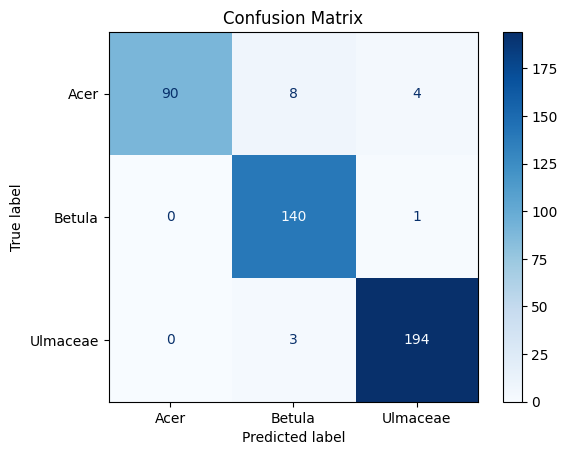

In [ ]:
# ===== 模型评估 =====
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 在 test_dl 上收集预测
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        all_preds.append(model(x).argmax(1).cpu())
        all_labels.append(y)
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# --- 1. 文本报告 ---
print(f"TEST Acc: {(all_preds == all_labels).mean()*100:.2f}%")
print(classification_report(all_labels, all_preds, target_names=full_ds.classes))

# --- 2. 混淆矩阵可视化 ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_ds.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 统计分析

换算比例尺

In [ ]:
# 原始图像尺寸
import cv2

# 图像路径
img_path = "/content/drive/MyDrive/my_dataset/Acer_BM_3678_Acer_monospessulatum_grid_preview.png"

# 读取图像
img = cv2.imread(img_path)

if img is None:
    print("图像无法读取，请检查路径")
else:
    height, width = img.shape[:2]
    print(f"Image dimensions: width = {width} pixels, height = {height} pixels")

Image dimensions: width = 28191 pixels, height = 25963 pixels


Scale bar length: 3042 pixel
Scale ratio: 1 pixel ≈ 0.16 μm


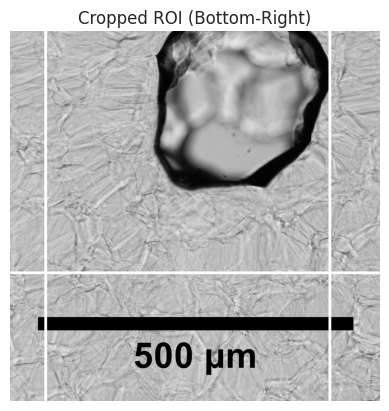

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
img_path = "/content/drive/MyDrive/my_dataset/Acer_BM_3678_Acer_monospessulatum_grid_preview.png"
real_length_um = 500  # 图像标注的比例尺实际长度（单位：μm）
crop_height = 4000   # 裁剪区域高度（像素）
crop_width = 4000   # 裁剪区域宽度（像素）

img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError("Image read failed")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = gray.shape

# 裁剪右下角区域（包含比例尺线
roi = gray[h - crop_height : h, w - crop_width : w]

# 图像二值化（找出黑色线条）
_, binary = cv2.threshold(255 - roi, 200, 255, cv2.THRESH_BINARY)

# 查找轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 寻找最长的横线段
max_len = 0
scale_bar_length = None
for cnt in contours:
    x, y, w_box, h_box = cv2.boundingRect(cnt)
    if w_box > max_len and h_box < w_box * 0.3:  # 水平线
        max_len = w_box
        scale_bar_length = w_box

# 输出换算结果
if scale_bar_length:
    um_per_pixel = real_length_um / scale_bar_length
    print(f"Scale bar length: {scale_bar_length} pixel")
    print(f"Scale ratio: 1 pixel ≈ {um_per_pixel:.2f} μm")
else:
    print("Scale line segment not recognized")

# Region of Interest
plt.imshow(roi, cmap='gray')
plt.title("Cropped ROI (Bottom-Right)")
plt.axis("off")
plt.show()


In [ ]:
# Calculate μm/pixel of the original image
# μm_per_pixel_original = 500 / 3042 ≈ 0.1644 μm/pixel

# Calculate downsample scaling
# scale_factor = 3072 / 512

# Analyze images in μm/pixel
# μm_per_pixel_analysis = 0.1644 × 6 = 0.9864 μm/pixel

PIXEL_SIZE = 0.9864  # μm/pixel



Get the size of each pollen image

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import re  # 用于提取 slide_id

# 输入路径（透明花粉图像）
base_dir = "/content/drive/MyDrive/my_dataset/MaskedTransparent"
species_list = ["Acer", "Betula", "Ulmaceae"]

results = []

# 遍历每个物种子文件夹
for species in species_list:
    folder = os.path.join(base_dir, species)
    if not os.path.isdir(folder):
        continue

    for fname in tqdm(os.listdir(folder), desc=f"Processing {species}"):
        if not fname.lower().endswith(".png"):
            continue
        path = os.path.join(folder, fname)

        # 读取透明图像（保留 alpha 通道）
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None or img.shape[2] != 4:
            continue

        # 提取 alpha 通道
        alpha = img[:, :, 3]
        area = int(np.sum(alpha > 0))

        # 提取 slide_id
        match_slide = re.search(r"(BM_\d+)", fname)
        slide_id = match_slide.group(1) if match_slide else "BM_xxxx"

        results.append({
            "filename": fname,
            "species": species,
            "area_pixels": area,
            "slide_id": slide_id
        })

# 保存为 CSV 文件
df = pd.DataFrame(results)
csv_path = "/content/drive/MyDrive/my_dataset/pollen_area_stats_with_slide.csv"
df.to_csv(csv_path, index=False)
print(f"Size data with slide ID saved: {csv_path}")


Processing Ulmaceae: 100%|██████████| 12259/12259 [02:50<00:00, 72.06it/s] 


Size data with slide ID saved: /content/drive/MyDrive/my_dataset/pollen_area_stats_with_slide.csv


核密度估计曲线（KDE 图）

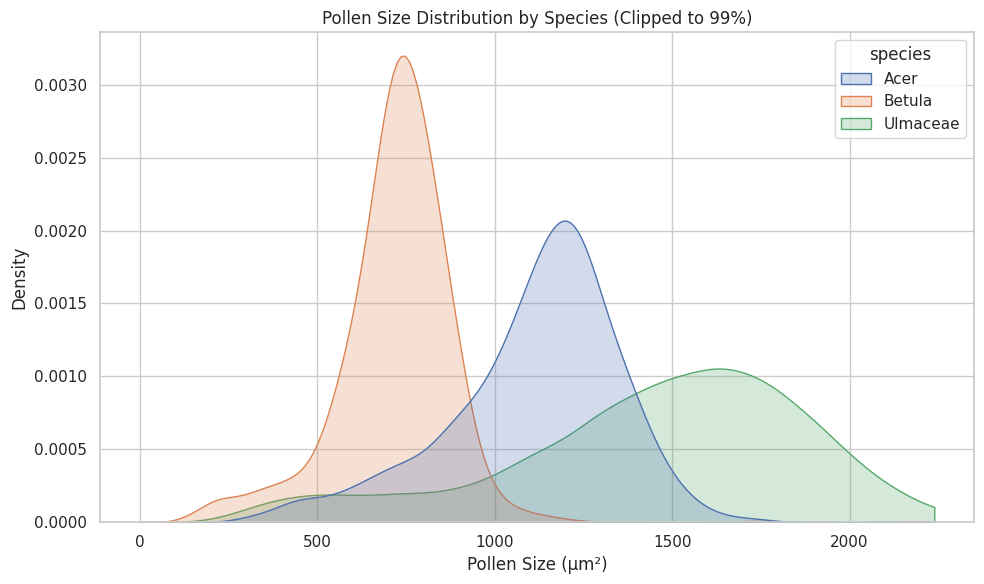

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
csv_path = "/content/drive/MyDrive/my_dataset/pollen_area_stats_with_slide.csv"
df = pd.read_csv(csv_path)

# 真实面积
PIXEL_SIZE = 0.9864  # μm/pixel
df["area_um2"] = df["area_pixels"] * (PIXEL_SIZE ** 2)

# 计算全体样本的 99% 分位值
max_area = df["area_um2"].quantile(0.99)

# 画 KDE 图（限制横轴显示范围）
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="area_um2", hue="species", fill=True,
            common_norm=False, clip=(0, max_area))
plt.title("Pollen Size Distribution by Species (Clipped to 99%)")
plt.xlabel("Pollen Size (μm²)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


柱状图

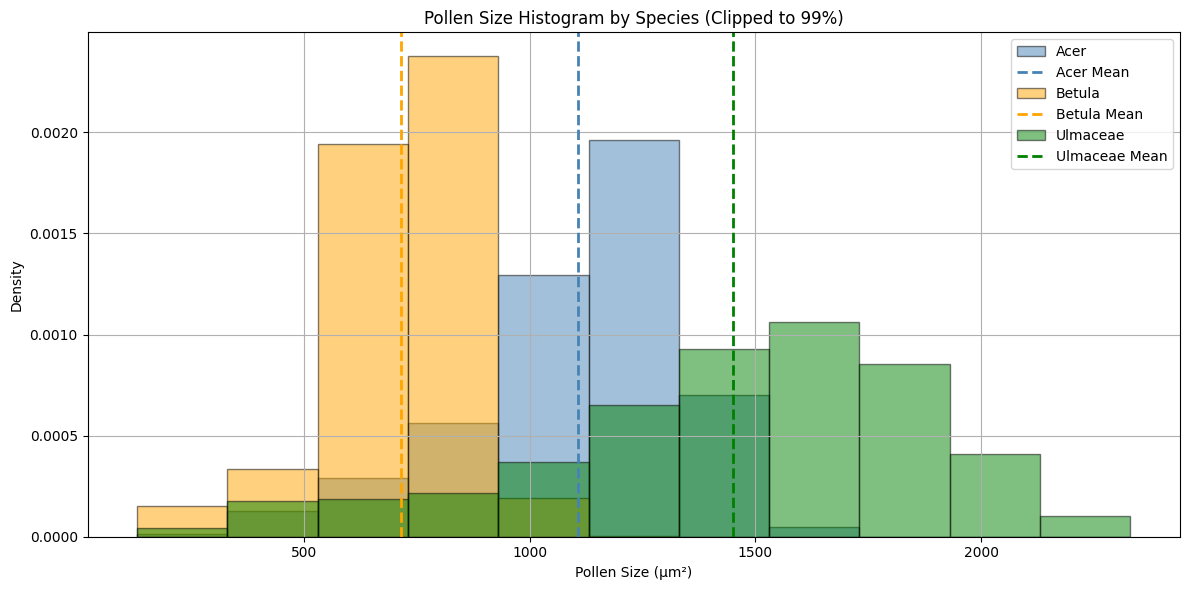

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取面积数据
csv_path = "/content/drive/MyDrive/my_dataset/pollen_area_stats_with_slide.csv"
df = pd.read_csv(csv_path)

# 添加真实单位列
PIXEL_SIZE = 0.9864  # μm/pixel
df["area_um2"] = df["area_pixels"] * (PIXEL_SIZE ** 2)

# 过滤每个物种前99%的数据
filtered_data = {}
quantiles = {}
for sp in df["species"].unique():
    sp_data = df[df["species"] == sp]
    upper = sp_data["area_um2"].quantile(0.99)
    quantiles[sp] = upper
    filtered_data[sp] = sp_data[sp_data["area_um2"] <= upper]["area_um2"].values

colors = {
    "Acer": "steelblue",
    "Betula": "orange",
    "Ulmaceae": "green"
}

# 设置 bin 范围（使用所有过滤后数据的最大值）
all_filtered = np.concatenate(list(filtered_data.values()))
bin_width_um2 = 200
min_val = all_filtered.min()
max_val = all_filtered.max()
bin_edges = np.arange(min_val, max_val + bin_width_um2, bin_width_um2)

# 绘图
plt.figure(figsize=(12, 6))

for species in filtered_data:
    data = filtered_data[species]
    plt.hist(data,
             bins=bin_edges,
             alpha=0.5,
             density=True,
             label=species,
             color=colors[species],
             edgecolor='black')

    # 添加均值线（μm²）
    plt.axvline(data.mean(),
                color=colors[species],
                linestyle='--',
                linewidth=2,
                label=f"{species} Mean")

# 图表信息
plt.xlabel("Pollen Size (μm²)")
plt.ylabel("Density")
plt.title("Pollen Size Histogram by Species (Clipped to 99%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


major axis and minor axis

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import re  # 用于提取 slide_id

# 设置路径和物种
base_dir = "/content/drive/MyDrive/my_dataset/MaskedTransparent"
species_list = ["Acer", "Betula", "Ulmaceae"]

results = []

for sp in species_list:
    sp_dir = os.path.join(base_dir, sp)

    for fname in tqdm(os.listdir(sp_dir), desc=f"Processing {sp}"):
        if not fname.lower().endswith(".png"):
            continue
        fpath = os.path.join(sp_dir, fname)

        img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
        if img is None or img.shape[2] != 4:
            continue

        alpha = img[:, :, 3]
        mask = (alpha > 0).astype(np.uint8) * 255

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        cnt = max(contours, key=cv2.contourArea)
        if len(cnt) < 5:
            continue

        # 拟合椭圆
        ellipse = cv2.fitEllipse(cnt)
        (cx, cy), (major, minor), angle = ellipse
        area = cv2.contourArea(cnt)

        if area > 10000:  # 排除明显粘连或超大异常
            continue

        ratio = max(major, minor) / min(major, minor)
        if ratio > 4.0:  # 排除特别细长异常
            continue

        # 提取 slide_id
        match_slide = re.search(r"(BM_\d+)", fname)
        slide_id = match_slide.group(1) if match_slide else "BM_xxxx"

        results.append({
            "filename": fname,
            "species": sp,
            "major_axis": max(major, minor),
            "minor_axis": min(major, minor),
            "axis_ratio": ratio,
            "area": area,
            "slide_id": slide_id
        })

# 保存为 CSV
df = pd.DataFrame(results)
save_path = "/content/drive/MyDrive/my_dataset/pollen_ellipse_measurements_with_slide.csv"
df.to_csv(save_path, index=False)
print(f"Saved to {save_path}")


Processing Ulmaceae: 100%|██████████| 12259/12259 [03:09<00:00, 64.75it/s] 


Saved to /content/drive/MyDrive/my_dataset/pollen_ellipse_measurements_with_slide.csv


取前99%的数据

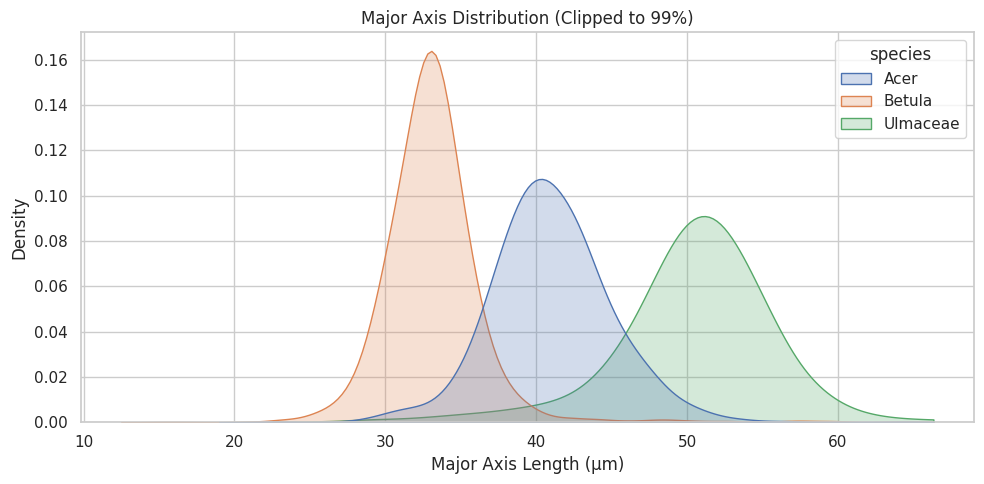

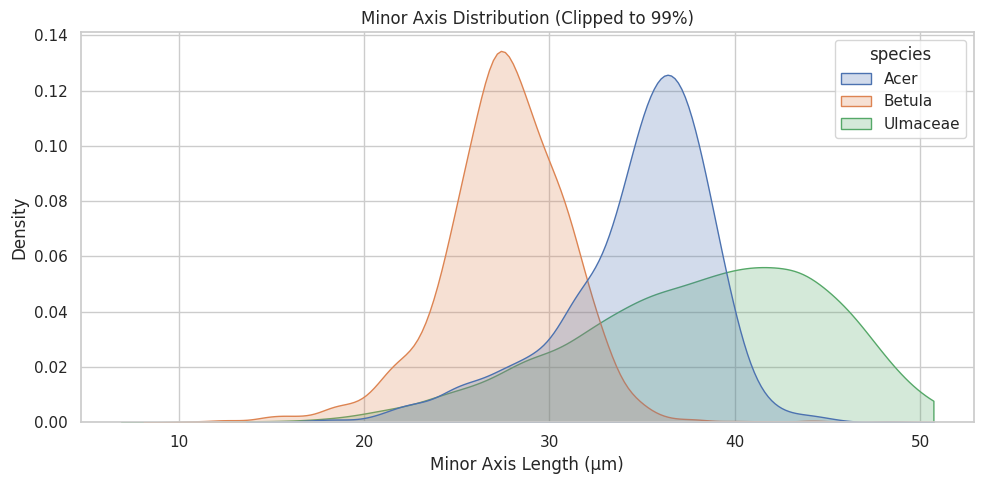

In [ ]:
# Unit conversion
df["major_um"] = df["major_axis"] * PIXEL_SIZE
df["minor_um"] = df["minor_axis"] * PIXEL_SIZE


# Calculate the 99% quantile as the right boundary
max_major = df["major_um"].quantile(0.99)
max_minor = df["minor_um"].quantile(0.99)

# KDE image: major axis
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x="major_um", hue="species", fill=True,
            common_norm=False, clip=(0, max_major))
plt.title("Major Axis Distribution (Clipped to 99%)")
plt.xlabel("Major Axis Length (μm)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# KDE image: minor axis
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x="minor_um", hue="species", fill=True,
            common_norm=False, clip=(0, max_minor))
plt.title("Minor Axis Distribution (Clipped to 99%)")
plt.xlabel("Minor Axis Length (μm)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


ellipticity

Mean ellipticity (per species):
species
Acer        0.153062
Betula      0.166182
Ulmaceae    0.242930
Name: ellipticity, dtype: float64


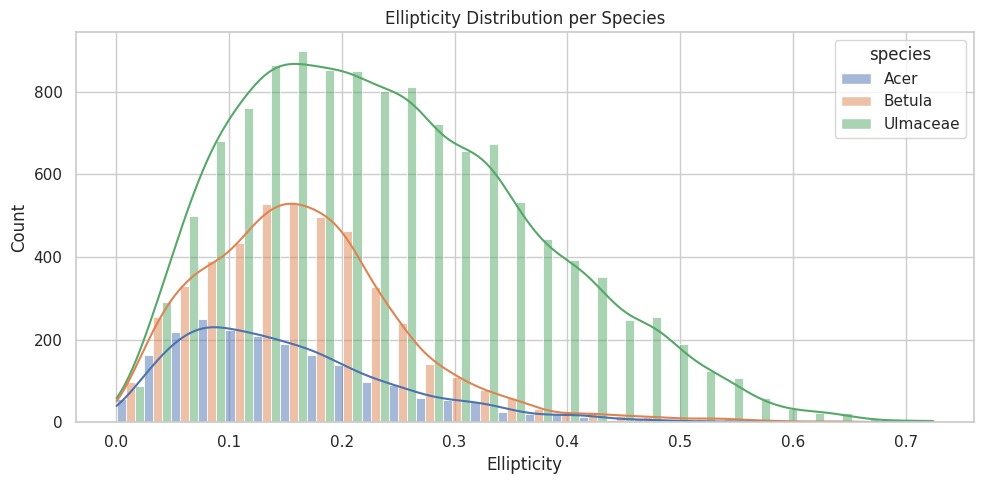

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取测量数据
df = pd.read_csv("/content/drive/MyDrive/my_dataset/pollen_ellipse_measurements_with_slide.csv")

# 像素转微米
PIXEL_SIZE = 0.9864  # μm/pixel
df["major_um"] = df["major_axis"] * PIXEL_SIZE
df["minor_um"] = df["minor_axis"] * PIXEL_SIZE

# 使用真实距离计算椭圆性
df['ellipticity'] = 1 - df['minor_um'] / df['major_um']

# 平均椭圆性（每个物种）
mean_ellipticity = df.groupby("species")["ellipticity"].mean()
print("Mean ellipticity (per species):")
print(mean_ellipticity)

# 绘图
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="ellipticity", hue="species",
             bins=30, multiple="dodge", kde=True)
plt.title("Ellipticity Distribution per Species")
plt.xlabel("Ellipticity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# To compare the morphological differences (e.g., area, major axis, minor axis, ellipticity) between Acer monspessulanum and Betula pendula in two different countries and explore the possible reasons.

总表格

In [ ]:
import pandas as pd

# 读取数据
area_path = "/content/drive/MyDrive/my_dataset/pollen_area_stats_with_slide.csv"
ellipse_path = "/content/drive/MyDrive/my_dataset/pollen_ellipse_measurements_with_slide.csv"
slide_info_path = "/content/drive/MyDrive/my_dataset/List_of_Slides.xlsx"

area_df = pd.read_csv(area_path)
ellipse_df = pd.read_csv(ellipse_path)
slide_df = pd.read_excel(slide_info_path)

# 合并面积和形态数据
merged_df = pd.merge(ellipse_df, area_df[["filename", "area_pixels"]], on="filename", how="left")

# 单位换算
PIXEL_SIZE = 0.9864
merged_df["major_um"] = merged_df["major_axis"] * PIXEL_SIZE
merged_df["minor_um"] = merged_df["minor_axis"] * PIXEL_SIZE
merged_df["area_um2"] = merged_df["area_pixels"] * (PIXEL_SIZE ** 2)

# 计算椭圆度
merged_df["ellipticity"] = 1 - merged_df["minor_um"] / merged_df["major_um"]

# 添加 country 信息
slide_df["slide_id"] = slide_df["specimen number"].apply(lambda x: str(x).replace(" ", "_").strip())
slide_df["country"] = slide_df["COUNTRY"].str.strip()
merged_df = pd.merge(merged_df, slide_df[["slide_id", "country"]], on="slide_id", how="left")

# 整理列顺序
final_df = merged_df[[
    "filename", "species", "slide_id", "country",
    "area_pixels", "area_um2",
    "major_axis", "minor_axis", "major_um", "minor_um",
    "axis_ratio", "ellipticity"
]]

# 保存为 Excel 文件
output_path = "/content/drive/MyDrive/my_dataset/morphology_summary.xlsx"
final_df.to_excel(output_path, index=False)
print(f"Saved successfully: {output_path}")


Saved successfully: /content/drive/MyDrive/my_dataset/morphology_summary.xlsx


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取花粉形态数据
df = pd.read_excel("/content/drive/MyDrive/my_dataset/morphology_summary.xlsx")

# 按物种筛选
acer_df = df[df["species"] == "Acer"]
betula_df = df[df["species"] == "Betula"]

# 计算全体样本的 99% 分位数
q_area = df["area_um2"].quantile(0.99)
q_major = df["major_um"].quantile(0.99)
q_elli = df["ellipticity"].quantile(0.99)


Acer分布对比图

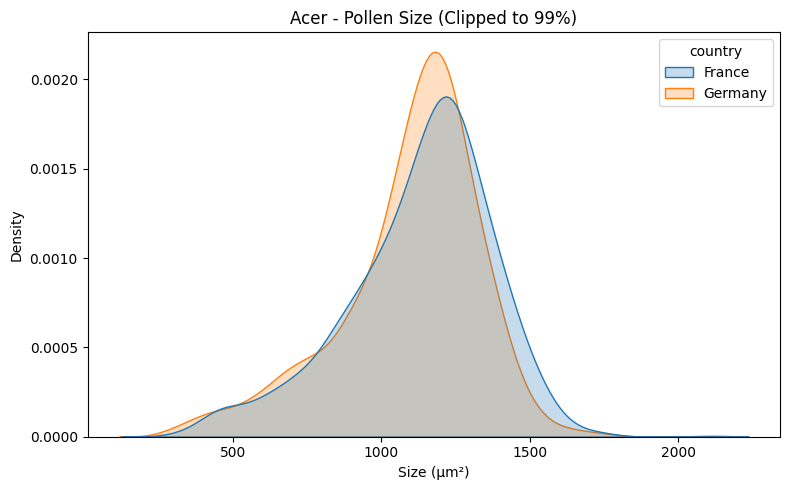

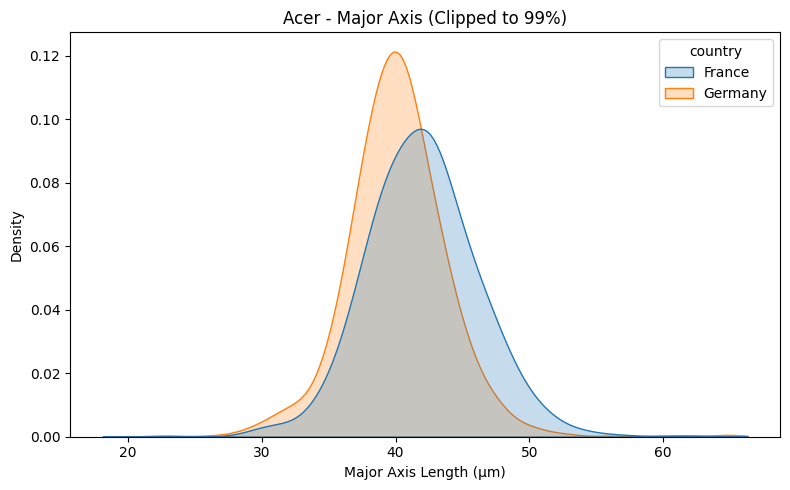

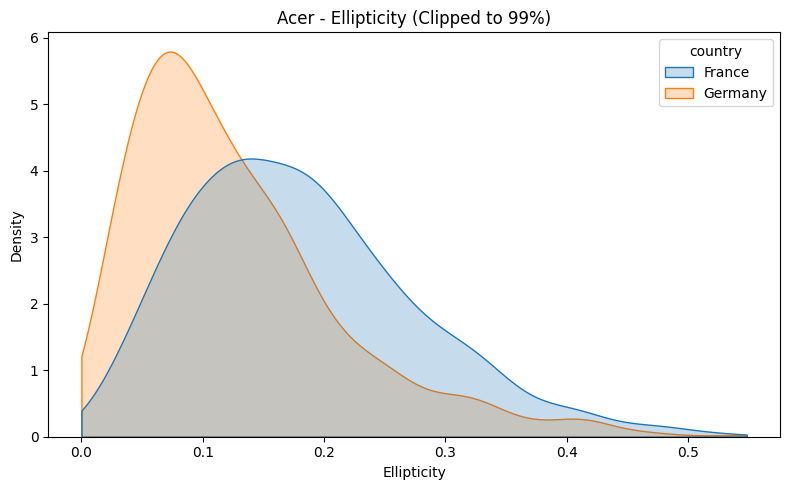

In [ ]:
# pollen size
plt.figure(figsize=(8, 5))
sns.kdeplot(data=acer_df, x="area_um2", hue="country", fill=True, common_norm=False, clip=(0, q_area))
plt.title("Acer - Pollen Size (Clipped to 99%)")
plt.xlabel("Size (μm²)")
plt.tight_layout()
plt.show()

# major axis
plt.figure(figsize=(8, 5))
sns.kdeplot(data=acer_df, x="major_um", hue="country", fill=True, common_norm=False, clip=(0, q_major))
plt.title("Acer - Major Axis (Clipped to 99%)")
plt.xlabel("Major Axis Length (μm)")
plt.tight_layout()
plt.show()

# ellipticity
plt.figure(figsize=(8, 5))
sns.kdeplot(data=acer_df, x="ellipticity", hue="country", fill=True, common_norm=False, clip=(0, q_elli))
plt.title("Acer - Ellipticity (Clipped to 99%)")
plt.xlabel("Ellipticity")
plt.tight_layout()
plt.show()


Betula分布对比图

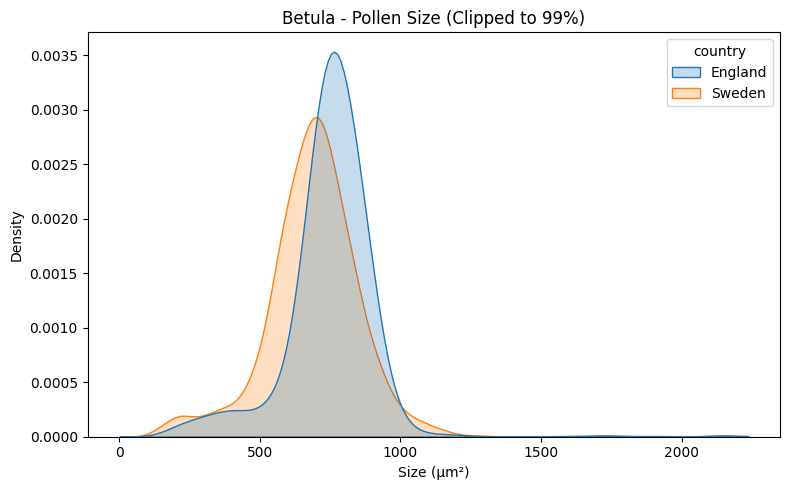

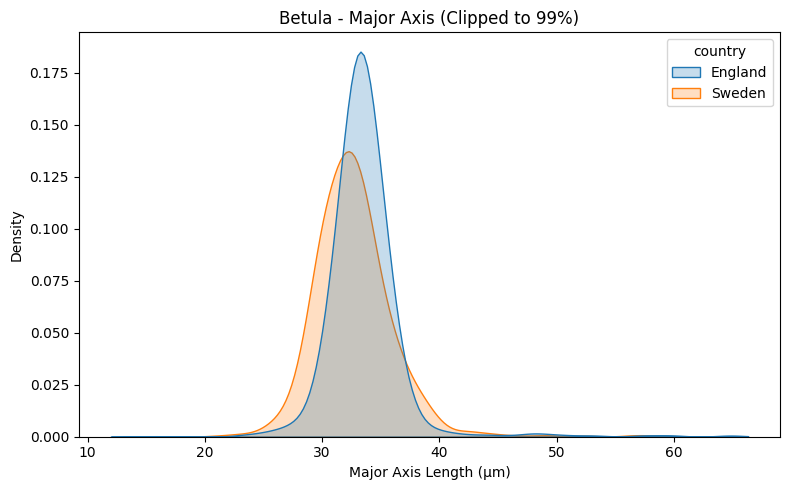

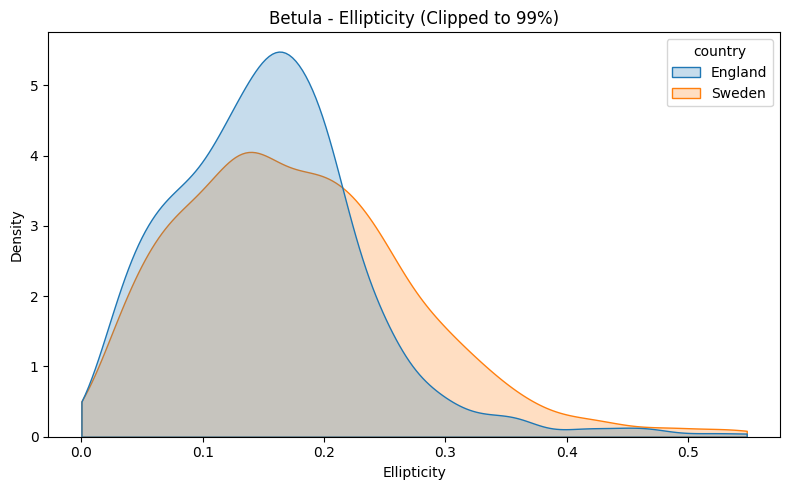

In [ ]:
# pollen size
plt.figure(figsize=(8, 5))
sns.kdeplot(data=betula_df, x="area_um2", hue="country", fill=True, common_norm=False, clip=(0, q_area))
plt.title("Betula - Pollen Size (Clipped to 99%)")
plt.xlabel("Size (μm²)")
plt.tight_layout()
plt.show()

# major axis
plt.figure(figsize=(8, 5))
sns.kdeplot(data=betula_df, x="major_um", hue="country", fill=True, common_norm=False, clip=(0, q_major))
plt.title("Betula - Major Axis (Clipped to 99%)")
plt.xlabel("Major Axis Length (μm)")
plt.tight_layout()
plt.show()

# ellipticity
plt.figure(figsize=(8, 5))
sns.kdeplot(data=betula_df, x="ellipticity", hue="country", fill=True, common_norm=False, clip=(0, q_elli))
plt.title("Betula - Ellipticity (Clipped to 99%)")
plt.xlabel("Ellipticity")
plt.tight_layout()
plt.show()


KS检验

Null Hypothesis (H₀):
The Acer pollen area in France and Germany follows the same distribution (no significant difference).

Alternative Hypothesis (H₁):
The Acer pollen area in France and Germany has a different distribution.

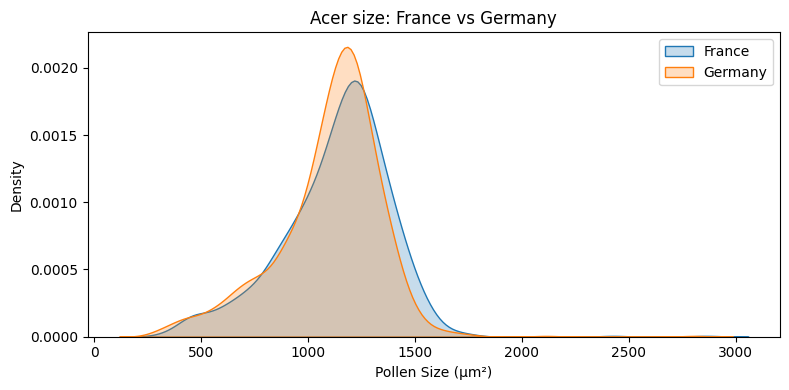

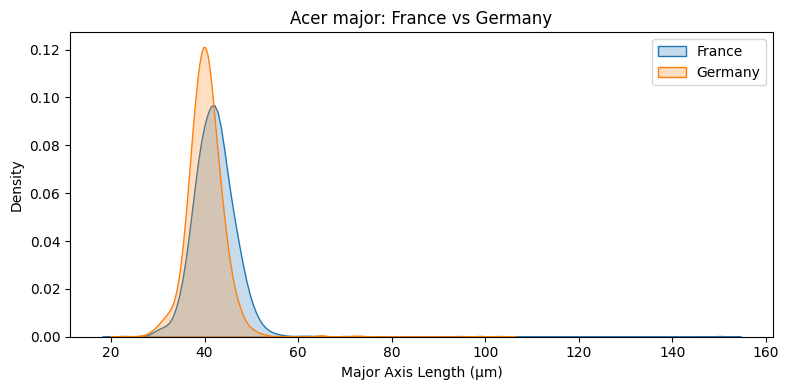

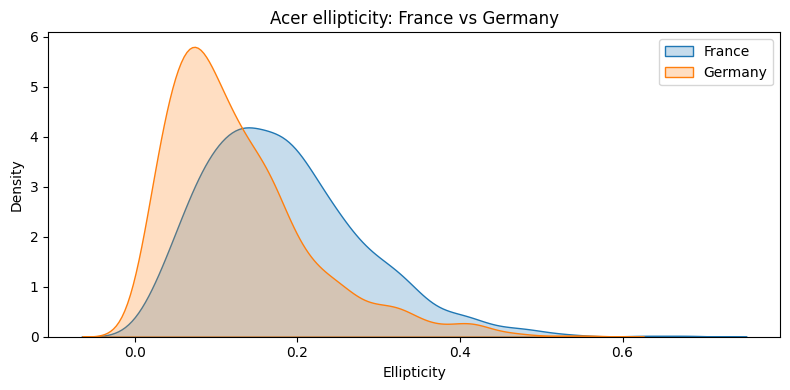

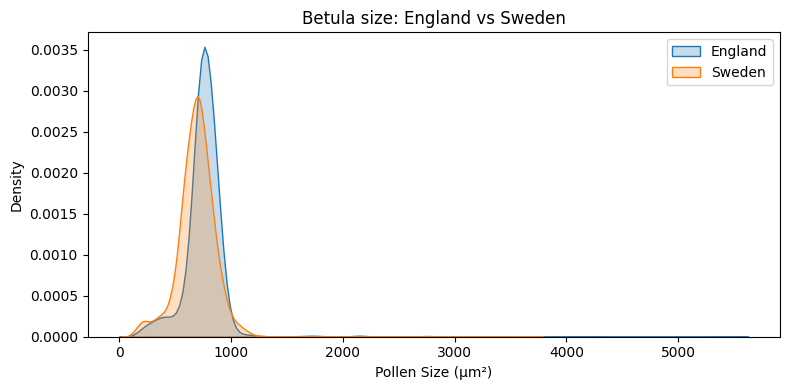

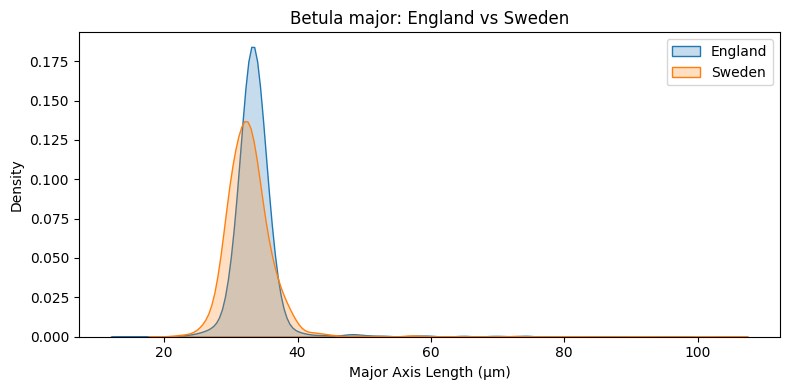

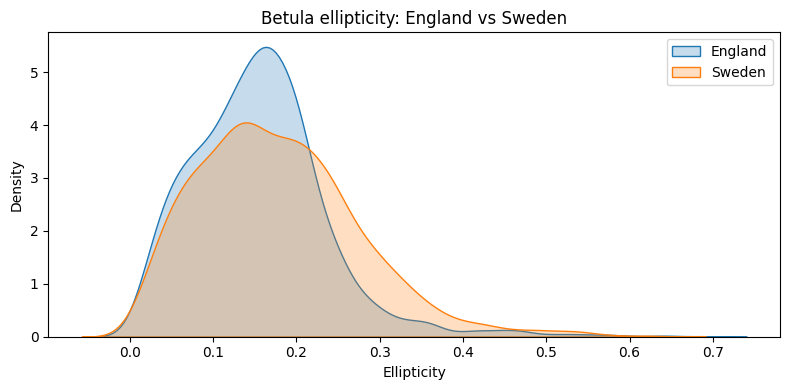

,Species,Feature,Country1,Country2,KS Statistic,p-value,Significant
0,Acer,size,France,Germany,0.0910,3.82e-04,Yes
1,Acer,major,France,Germany,0.2358,1.87e-25,Yes
2,Acer,ellipticity,France,Germany,0.2871,1.15e-37,Yes
3,Betula,size,England,Sweden,0.2569,1.90e-67,Yes
4,Betula,major,England,Sweden,0.2170,4.30e-48,Yes
5,Betula,ellipticity,England,Sweden,0.1592,5.46e-26,Yes


In [ ]:
import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_excel("/content/drive/MyDrive/my_dataset/morphology_summary.xlsx")

# 显示特征名
feature_name_map = {
    "area_um2": "size",
    "major_um": "major",
    "ellipticity": "ellipticity"
}

# 横坐标标签带单位
xlabel_map = {
    "area_um2": "Pollen Size (µm²)",
    "major_um": "Major Axis Length (µm)",
    "ellipticity": "Ellipticity"
}

# KS 检验函数
def run_ks(species, country1, country2, feature):
    subset = df[df["species"] == species]
    data1 = subset[subset["country"] == country1][feature].dropna()
    data2 = subset[subset["country"] == country2][feature].dropna()

    if len(data1) < 2 or len(data2) < 2:
        return {
            "Species": species,
            "Feature": feature_name_map.get(feature, feature),
            "Country1": country1,
            "Country2": country2,
            "KS Statistic": None,
            "p-value": None,
            "Significant": "Too few data"
        }

    stat, p = ks_2samp(data1, data2)
    significant = "Yes" if p < 0.05 else "No"

    # 绘图显示
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data1, label=country1, fill=True)
    sns.kdeplot(data2, label=country2, fill=True)
    plt.xlabel(xlabel_map.get(feature, feature))
    plt.title(f"{species} {feature_name_map.get(feature, feature)}: {country1} vs {country2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Species": species,
        "Feature": feature_name_map.get(feature, feature),
        "Country1": country1,
        "Country2": country2,
        "KS Statistic": round(stat, 4),
        "p-value": f"{p:.2e}",
        "Significant": significant
    }

# 设置比较项目
comparisons = [
    ("Acer", "France", "Germany", "area_um2"),
    ("Acer", "France", "Germany", "major_um"),
    ("Acer", "France", "Germany", "ellipticity"),
    ("Betula", "England", "Sweden", "area_um2"),
    ("Betula", "England", "Sweden", "major_um"),
    ("Betula", "England", "Sweden", "ellipticity"),
]

# 执行检验
results = [run_ks(sp, c1, c2, feat) for sp, c1, c2, feat in comparisons]
ks_results_df = pd.DataFrame(results)

# 显示结果表
ks_results_df


文件夹数量检验

In [ ]:
import os
from collections import defaultdict

base_dir = "/content/drive/MyDrive/my_dataset/Classification"
species_list = ["Acer", "Betula", "Ulmaceae"]

counts_classification = {}
for sp in species_list:
    folder = os.path.join(base_dir, sp)
    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    counts_classification[sp] = len(files)

print("Classification (非透明图像):")
for sp, count in counts_classification.items():
    print(f"{sp}: {count} images")


📁 Classification (非透明图像):
Acer: 677 images
Betula: 933 images
Ulmaceae: 1350 images


In [ ]:
base_dir = "/content/drive/MyDrive/my_dataset/Classification_uniform"
counts_uniform = {}
for sp in species_list:
    folder = os.path.join(base_dir, sp)
    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    counts_uniform[sp] = len(files)

print("Classification_uniform (84x84 灰度图):")
for sp, count in counts_uniform.items():
    print(f"{sp}: {count} images")


📁 Classification_uniform (84x84 灰度图):
Acer: 677 images
Betula: 933 images
Ulmaceae: 1350 images


In [ ]:
base_dir = "/content/drive/MyDrive/my_dataset/MaskedTransparent"
counts_masked = {}
for sp in species_list:
    folder = os.path.join(base_dir, sp)
    files = [f for f in os.listdir(folder) if f.endswith(".png")]
    counts_masked[sp] = len(files)

print("MaskedTransparent (透明图像):")
for sp, count in counts_masked.items():
    print(f"{sp}: {count} images")


📁 MaskedTransparent (透明图像):
Acer: 2056 images
Betula: 4626 images
Ulmaceae: 12259 images
